<a href="https://colab.research.google.com/github/emilioluisen/TACODataset/blob/main/CapstoneTACODataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/MyDataset

/content/gdrive/MyDrive/MyDataset


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


modules loaded


In [16]:
#Getting Class Names and importing the yaml and directories available from the dataset
import yaml

with open('/content/gdrive/MyDrive/MyDataset/TacoYolo/data.yaml', 'r') as file:
    data_yaml = yaml.safe_load(file)

class_names = data_yaml['names']

dataset_params = {
    'data_dir': '/content/gdrive/MyDrive/MyDataset/TacoYolo',
    'train_images_dir': '/content/gdrive/MyDrive/MyDataset/TacoYolo/train/images',
    'train_labels_dir': '/content/gdrive/MyDrive/MyDataset/TacoYolo/train/labels',
    'val_images_dir': '/content/gdrive/MyDrive/MyDataset/TacoYolo/valid/images',
    'val_labels_dir': '/content/gdrive/MyDrive/MyDataset/TacoYolo/valid/labels',
    'test_images_dir': '/content/gdrive/MyDrive/MyDataset/TacoYolo/test/images',
    'test_labels_dir': '/content/gdrive/MyDrive/MyDataset/TacoYolo/test/labels',
    'classes': class_names
}

In [17]:
#Trial to see the class names available and validate if it matches the yaml
print(class_names)

['Aluminium foil', 'Bottle cap', 'Bottle', 'Broken glass', 'Can', 'Carton', 'Cigarette', 'Cup', 'Lid', 'Other litter', 'Other plastic', 'Paper', 'Plastic bag - wrapper', 'Plastic container', 'Pop tab', 'Straw', 'Styrofoam piece', 'Unlabeled litter']


In [18]:
import os
import glob

# Defining the path with the labels from the training set
train_annotation_dir = dataset_params['train_labels_dir']

# Creating a directory
image_class_names = {}

# Determining the classes based on the label
for annotation_file in glob.glob(os.path.join(train_annotation_dir, '*.txt')):
    with open(annotation_file, 'r') as file:
        lines = file.read().strip().split('\n')

    class_names = []

    for line in lines:
        parts = line.split()
        class_id = int(parts[0])

        if class_id < len(dataset_params['classes']):
            class_name = dataset_params['classes'][class_id]
            class_names.append(class_name)

    image_file = annotation_file.replace('.txt', '.jpg')

    # Concatanating class names with th eimage
    image_class_names[os.path.basename(image_file)] = ', '.join(class_names)

In [19]:
# Validating if the images will show the classes
for i, (image_file, class_names) in enumerate(image_class_names.items()):
    if i >= 5:
        break
    print(f"Classes for {image_file}: {class_names}")

Classes for 000067_JPG_jpg.rf.cf98a10603f2e8c5dea5ee03838a12f7.jpg: Plastic bag - wrapper, Other plastic
Classes for 000067_JPG_jpg.rf.c57fa9c32c423225656bce13e81a31ca.jpg: Carton
Classes for 000066_jpg.rf.fe9119d7be20104e86d439a85023675a.jpg: Bottle
Classes for 000067_JPG_jpg.rf.01bfc2afd473a8547c9533f12d7a19da.jpg: Plastic bag - wrapper
Classes for 000067_JPG_jpg.rf.7e1a8dc20de69584868d99f2f8f29462.jpg: Bottle cap, Unlabeled litter, Other plastic, Unlabeled litter, Unlabeled litter, Cigarette


In [21]:
#Creating directories for the classes, to be used later in training the model
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Creating the directory for bottle
output_dir = 'class_visualizations_bottle'
os.makedirs(output_dir, exist_ok=True)

# Defining the class
desired_class_name = 'Bottle cap'

# Visualizing the class specified
for image_file, class_names in image_class_names.items():
    if desired_class_name in class_names:
        image_path = os.path.join(dataset_params['train_images_dir'], image_file)
        image = Image.open(image_path)

        # Adding a plot
        plt.figure()
        plt.imshow(image)

        # Adding boxes
        with open(os.path.join(train_annotation_dir, image_file.replace('.jpg', '.txt')), 'r') as file:
            lines = file.read().strip().split('\n')
            for line in lines:
                parts = line.split()
                class_id = int(parts[0])
                if class_id < len(dataset_params['classes']) and dataset_params['classes'][class_id] == desired_class_name:
                    x_center, y_center, width, height = map(float, parts[1:])

                    # Convert relative coordinates to image coordinates
                    width *= image.width
                    height *= image.height
                    x_center *= image.width
                    y_center *= image.height

                    # Calculate the coordinates of the bounding box
                    x = x_center - width / 2
                    y = y_center - height / 2

                    # Create a rectangle patch for the bounding box
                    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')

                    # Add the bounding box to the plot
                    plt.gca().add_patch(rect)

        plt.title(f"Class: {desired_class_name}")
        plt.axis('off')

        # Saving the visualization in the class directory
        output_path = os.path.join(output_dir, image_file)
        plt.savefig(output_path, bbox_inches='tight')
        plt.close()


In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Creating the directory for straw
output_dir = 'class_visualizations_straw'
os.makedirs(output_dir, exist_ok=True)

# Defining the class
desired_class_name = 'Straw'

# Visualizing the class specified
for image_file, class_names in image_class_names.items():
    if desired_class_name in class_names:
        image_path = os.path.join(dataset_params['train_images_dir'], image_file)
        image = Image.open(image_path)

        # Adding a plot
        plt.figure()
        plt.imshow(image)

        # Adding bounding boxes
        with open(os.path.join(train_annotation_dir, image_file.replace('.jpg', '.txt')), 'r') as file:
            lines = file.read().strip().split('\n')
            for line in lines:
                parts = line.split()
                class_id = int(parts[0])
                if class_id < len(dataset_params['classes']) and dataset_params['classes'][class_id] == desired_class_name:
                    x_center, y_center, width, height = map(float, parts[1:])

                    # Convert relative coordinates to image coordinates
                    width *= image.width
                    height *= image.height
                    x_center *= image.width
                    y_center *= image.height

                    # Calculate the coordinates of the bounding box
                    x = x_center - width / 2
                    y = y_center - height / 2

                    # Create a rectangle patch for the bounding box
                    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')

                    # Add the bounding box
                    plt.gca().add_patch(rect)

        plt.title(f"Class: {desired_class_name}")
        plt.axis('off')

        # Saving the visualization in the class directory
        output_path = os.path.join(output_dir, image_file)
        plt.savefig(output_path, bbox_inches='tight')
        plt.close()


In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Creating the directory for cup
output_dir = 'class_visualizations_Cup'
os.makedirs(output_dir, exist_ok=True)

# Defining the class
desired_class_name = 'Cup'

# Visualizing the class specified
for image_file, class_names in image_class_names.items():
    if desired_class_name in class_names:
        image_path = os.path.join(dataset_params['train_images_dir'], image_file)
        image = Image.open(image_path)

        # Adding a plot
        plt.figure()
        plt.imshow(image)

        # Adding boxes
        with open(os.path.join(train_annotation_dir, image_file.replace('.jpg', '.txt')), 'r') as file:
            lines = file.read().strip().split('\n')
            for line in lines:
                parts = line.split()
                class_id = int(parts[0])
                if class_id < len(dataset_params['classes']) and dataset_params['classes'][class_id] == desired_class_name:
                    x_center, y_center, width, height = map(float, parts[1:])

                    # Convert relative coordinates to image coordinates
                    width *= image.width
                    height *= image.height
                    x_center *= image.width
                    y_center *= image.height

                    # Calculate the coordinates of the bounding box
                    x = x_center - width / 2
                    y = y_center - height / 2

                    # Create a rectangle patch for the bounding box
                    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')

                    # Add the bounding box to the plot
                    plt.gca().add_patch(rect)

        plt.title(f"Class: {desired_class_name}")
        plt.axis('off')

        # Saving the visualization in the class directory
        output_path = os.path.join(output_dir, image_file)
        plt.savefig(output_path, bbox_inches='tight')
        plt.close()


In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Creating the directory for can
output_dir = 'class_visualizations_Can'
os.makedirs(output_dir, exist_ok=True)

# Defining the class
desired_class_name = 'Can'

# Visualizing the class specified
for image_file, class_names in image_class_names.items():
    if desired_class_name in class_names:
        image_path = os.path.join(dataset_params['train_images_dir'], image_file)
        image = Image.open(image_path)

        # Adding a plot
        plt.figure()
        plt.imshow(image)

        # Adding boxes
        with open(os.path.join(train_annotation_dir, image_file.replace('.jpg', '.txt')), 'r') as file:
            lines = file.read().strip().split('\n')
            for line in lines:
                parts = line.split()
                class_id = int(parts[0])
                if class_id < len(dataset_params['classes']) and dataset_params['classes'][class_id] == desired_class_name:
                    x_center, y_center, width, height = map(float, parts[1:])

                    # Convert relative coordinates to image coordinates
                    width *= image.width
                    height *= image.height
                    x_center *= image.width
                    y_center *= image.height

                    # Calculate the coordinates of the bounding box
                    x = x_center - width / 2
                    y = y_center - height / 2

                    # Create a rectangle patch for the bounding box
                    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')

                    # Add the bounding box to the plot
                    plt.gca().add_patch(rect)

        plt.title(f"Class: {desired_class_name}")
        plt.axis('off')

        # Saving the visualization in the class directory
        output_path = os.path.join(output_dir, image_file)
        plt.savefig(output_path, bbox_inches='tight')
        plt.close()


In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Creating the directory for bottle cap
output_dir = 'class_visualizations_Bottle cap'
os.makedirs(output_dir, exist_ok=True)

# Defining the class
desired_class_name = 'Bottle cap'  # Replace with the specific class name you want to visualize

# Visualizing the class specified
for image_file, class_names in image_class_names.items():
    if desired_class_name in class_names:
        image_path = os.path.join(dataset_params['train_images_dir'], image_file)
        image = Image.open(image_path)

        # Adding a plot
        plt.figure()
        plt.imshow(image)

        # Adding boxes
        with open(os.path.join(train_annotation_dir, image_file.replace('.jpg', '.txt')), 'r') as file:
            lines = file.read().strip().split('\n')
            for line in lines:
                parts = line.split()
                class_id = int(parts[0])
                if class_id < len(dataset_params['classes']) and dataset_params['classes'][class_id] == desired_class_name:
                    x_center, y_center, width, height = map(float, parts[1:])

                    # Convert relative coordinates to image coordinates
                    width *= image.width
                    height *= image.height
                    x_center *= image.width
                    y_center *= image.height

                    # Calculate the coordinates of the bounding box
                    x = x_center - width / 2
                    y = y_center - height / 2

                    # Create a rectangle patch for the bounding box
                    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')

                    # Add the bounding box to the plot
                    plt.gca().add_patch(rect)

        plt.title(f"Class: {desired_class_name}")
        plt.axis('off')

        # Saving the visualization in the class directory
        output_path = os.path.join(output_dir, image_file)
        plt.savefig(output_path, bbox_inches='tight')
        plt.close()


In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Creating the directory for plastic bag
output_dir = 'class_visualizations_Plastic bag - wrapper'
os.makedirs(output_dir, exist_ok=True)

# Defining the class
desired_class_name = 'Plastic bag - wrapper'  # Replace with the specific class name you want to visualize

# Visualizing the class specified
for image_file, class_names in image_class_names.items():
    if desired_class_name in class_names:
        image_path = os.path.join(dataset_params['train_images_dir'], image_file)
        image = Image.open(image_path)

        # Adding a plot
        plt.figure()
        plt.imshow(image)

        # Adding boxes
        with open(os.path.join(train_annotation_dir, image_file.replace('.jpg', '.txt')), 'r') as file:
            lines = file.read().strip().split('\n')
            for line in lines:
                parts = line.split()
                class_id = int(parts[0])
                if class_id < len(dataset_params['classes']) and dataset_params['classes'][class_id] == desired_class_name:
                    x_center, y_center, width, height = map(float, parts[1:])

                    # Convert relative coordinates to image coordinates
                    width *= image.width
                    height *= image.height
                    x_center *= image.width
                    y_center *= image.height

                    # Calculate the coordinates of the bounding box
                    x = x_center - width / 2
                    y = y_center - height / 2

                    # Create a rectangle patch for the bounding box
                    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')

                    # Add the bounding box to the plot
                    plt.gca().add_patch(rect)

        plt.title(f"Class: {desired_class_name}")
        plt.axis('off')

        # Saving the visualization in the class directory
        output_path = os.path.join(output_dir, image_file)
        plt.savefig(output_path, bbox_inches='tight')
        plt.close()


In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Creating the directory for carton
output_dir = 'class_visualizations_Carton'
os.makedirs(output_dir, exist_ok=True)

# Defining the class
desired_class_name = 'Carton'  # Replace with the specific class name you want to visualize

# Visualizing the class specified
for image_file, class_names in image_class_names.items():
    if desired_class_name in class_names:
        image_path = os.path.join(dataset_params['train_images_dir'], image_file)
        image = Image.open(image_path)

        # Adding a plot
        plt.figure()
        plt.imshow(image)

        # Adding boxes
        with open(os.path.join(train_annotation_dir, image_file.replace('.jpg', '.txt')), 'r') as file:
            lines = file.read().strip().split('\n')
            for line in lines:
                parts = line.split()
                class_id = int(parts[0])
                if class_id < len(dataset_params['classes']) and dataset_params['classes'][class_id] == desired_class_name:
                    x_center, y_center, width, height = map(float, parts[1:])

                    # Convert relative coordinates to image coordinates
                    width *= image.width
                    height *= image.height
                    x_center *= image.width
                    y_center *= image.height

                    # Calculate the coordinates of the bounding box
                    x = x_center - width / 2
                    y = y_center - height / 2

                    # Create a rectangle patch for the bounding box
                    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')

                    # Add the bounding box to the plot
                    plt.gca().add_patch(rect)

        plt.title(f"Class: {desired_class_name}")
        plt.axis('off')

        # Saving the visualization in the class directory
        output_path = os.path.join(output_dir, image_file)
        plt.savefig(output_path, bbox_inches='tight')
        plt.close()


In [29]:
#Creating a dataframe
import os
import glob
import pandas as pd

#Defining the paths to the image and annotation directories
train_images_dir = dataset_params['train_images_dir']
train_labels_dir = dataset_params['train_labels_dir']

image_paths = []
class_names = []

#Loop through all images in train folder
for image_file in glob.glob(os.path.join(train_images_dir, '*.jpg')):
    annotation_file = os.path.join(train_labels_dir, os.path.basename(image_file).replace('.jpg', '.txt'))

    if os.path.exists(annotation_file):
        with open(annotation_file, 'r') as file:
            lines = file.read().strip().split('\n')

        # Extract class names from the annotation file
        class_names.extend([dataset_params['classes'][int(line.split()[0])] for line in lines])

        # Store image paths
        image_paths.extend([image_file] * len(lines))

#Creating a DataFrame to store the data
data = pd.DataFrame({'Image_Path': image_paths, 'Class_Name': class_names})

#Showing the first rows from the df
print(data.head())


                                          Image_Path             Class_Name
0  /content/gdrive/MyDrive/MyDataset/TacoYolo/tra...             Bottle cap
1  /content/gdrive/MyDrive/MyDataset/TacoYolo/tra...                 Bottle
2  /content/gdrive/MyDrive/MyDataset/TacoYolo/tra...                 Carton
3  /content/gdrive/MyDrive/MyDataset/TacoYolo/tra...                  Straw
4  /content/gdrive/MyDrive/MyDataset/TacoYolo/tra...  Plastic bag - wrapper


**EDA Steps/Questions**
*How does sample images look like from each class?*

````



ValueError: ignored

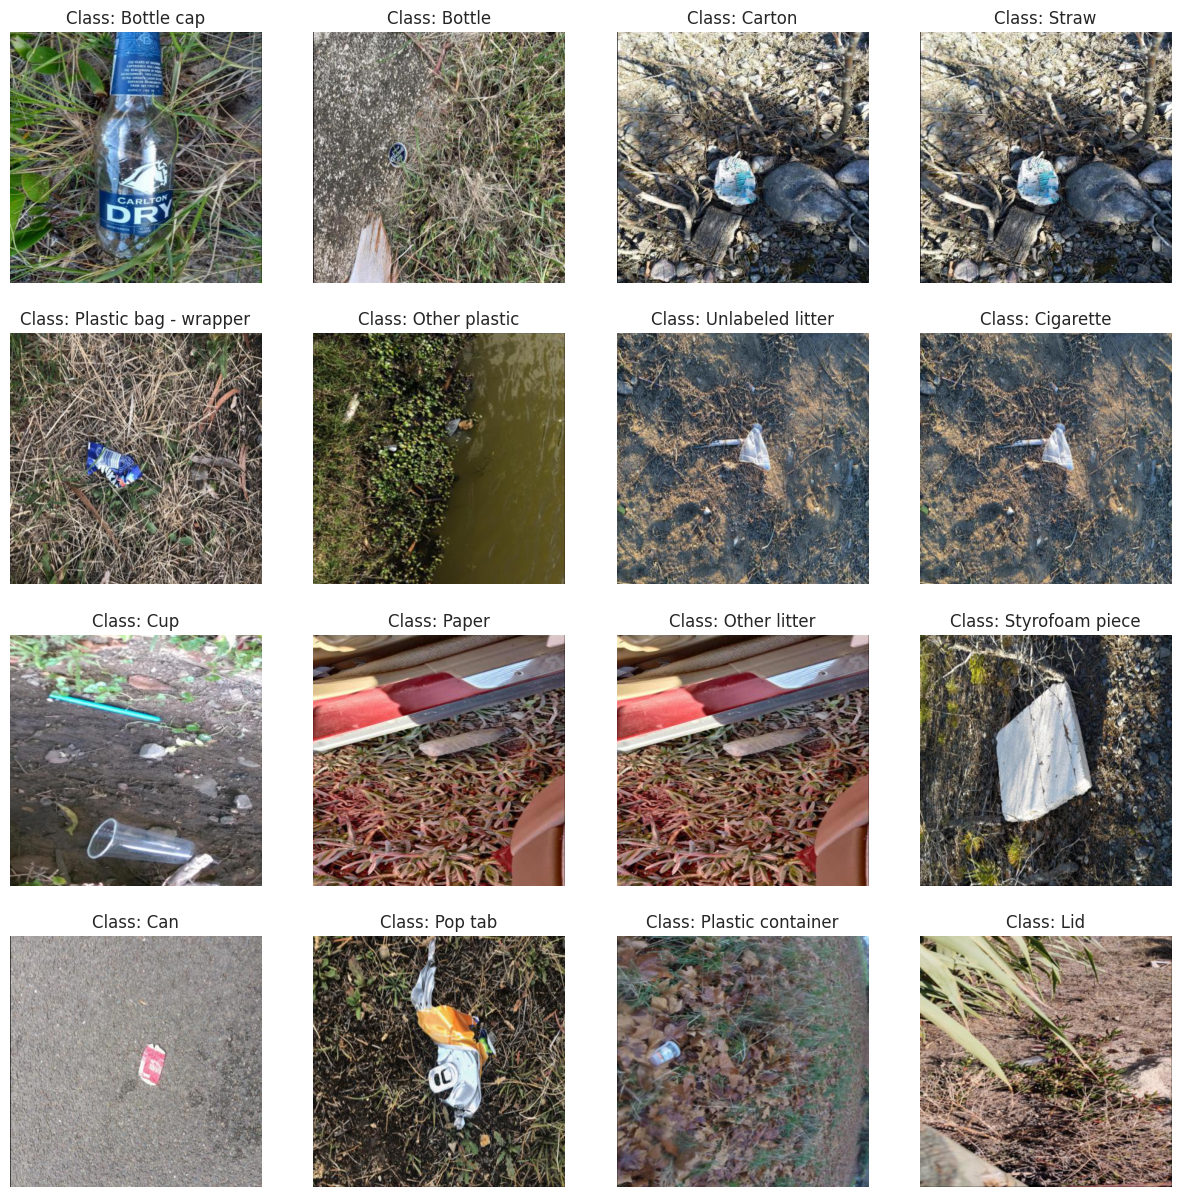

In [30]:
#Visualizing samples from each class
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

unique_classes = data['Class_Name'].unique()

#Creating a dictionary to store the first image path for each class
class_sample_images = {}

#Loop through unique classes and find the first image path for each
for class_name in unique_classes:
    first_image_path = data[data['Class_Name'] == class_name]['Image_Path'].iloc[0]
    class_sample_images[class_name] = first_image_path

#Visualizing the sample image for each class
plt.figure(figsize=(15, 15))
for i, (class_name, image_path) in enumerate(class_sample_images.items()):
    plt.subplot(4, 4, i + 1)
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'Class: {class_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [31]:
#Getting class name from last 5 image paths
data.tail(5)

Image_Path    Class_Name
13245  /content/gdrive/MyDrive/MyDataset/TacoYolo/tra...     Cigarette
13246  /content/gdrive/MyDrive/MyDataset/TacoYolo/tra...     Cigarette
13247  /content/gdrive/MyDrive/MyDataset/TacoYolo/tra...           Can
13248  /content/gdrive/MyDrive/MyDataset/TacoYolo/tra...    Bottle cap
13249  /content/gdrive/MyDrive/MyDataset/TacoYolo/tra...  Other litter

In [32]:
#Getting class name from first 5 image paths
data.head(5)

Image_Path             Class_Name
0  /content/gdrive/MyDrive/MyDataset/TacoYolo/tra...             Bottle cap
1  /content/gdrive/MyDrive/MyDataset/TacoYolo/tra...                 Bottle
2  /content/gdrive/MyDrive/MyDataset/TacoYolo/tra...                 Carton
3  /content/gdrive/MyDrive/MyDataset/TacoYolo/tra...                  Straw
4  /content/gdrive/MyDrive/MyDataset/TacoYolo/tra...  Plastic bag - wrapper

In [33]:
#Getting data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13250 entries, 0 to 13249
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_Path  13250 non-null  object
 1   Class_Name  13250 non-null  object
dtypes: object(2)
memory usage: 207.2+ KB


**EDA Steps/Questions**
*How does the original image look like - given specified paths?*



(<matplotlib.image.AxesImage at 0x7ecb6db78730>,
 Text(0.5, 1.0, 'Original image\n Straw'))

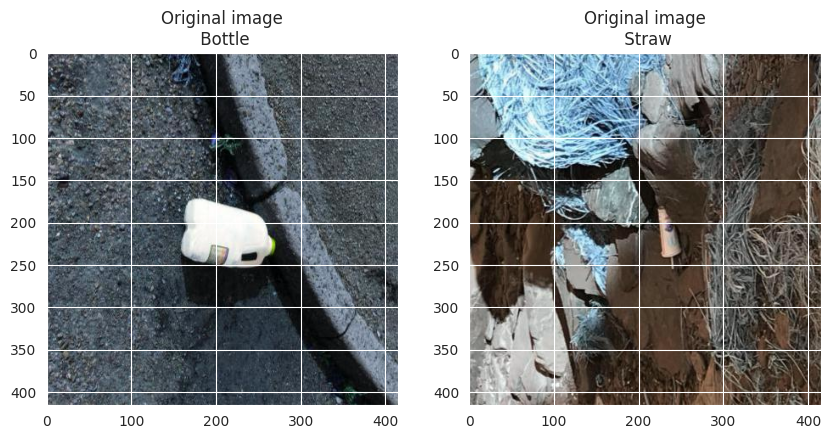

In [35]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
img_path_1 = '/content/gdrive/MyDrive/MyDataset/TacoYolo/train/images/000000_JPG_jpg.rf.2a350b240c67942b0c4a9e076fec45c4.jpg'
img_1 = cv2.imread(img_path_1)
img_path_2 = '/content/gdrive/MyDrive/MyDataset/TacoYolo/train/images/000002_jpg.rf.f23cfe1b27c3fe8aa5141920daf5e0ad.jpg'
img_2 = cv2.imread(img_path_2)
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(img_1),plt.title('Original image\n Bottle')
plt.subplot(122)
plt.imshow(img_2),plt.title('Original image\n Straw')

**EDA Steps/Questions**
*Given an image from a class, how will the image look like with geometrical transformations ?*



(<matplotlib.image.AxesImage at 0x7ecb5baa9f00>,
 Text(0.5, 1.0, 'Transposed image\n Straw'))

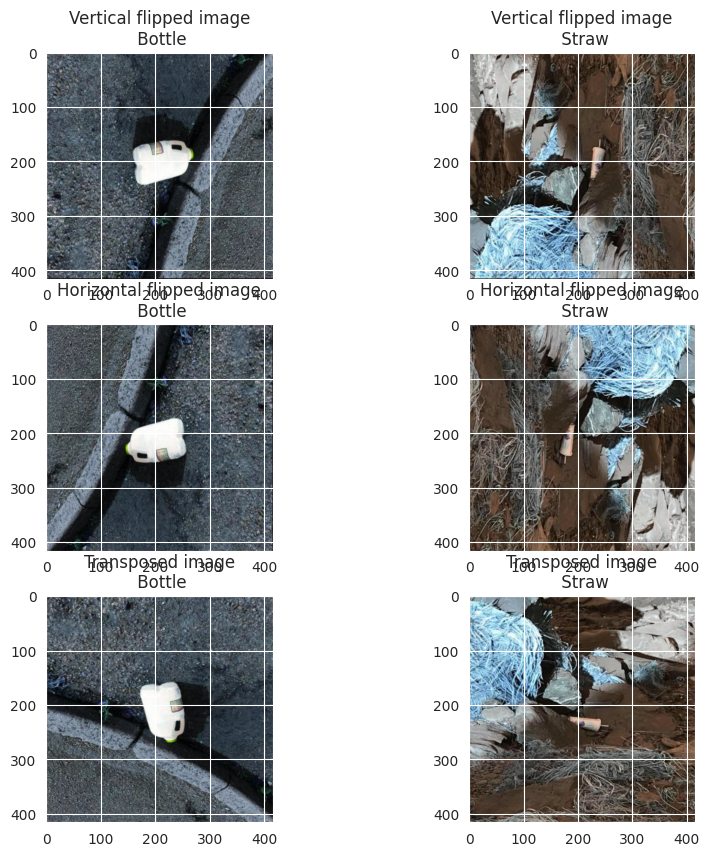

In [36]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img_path_1 = '/content/gdrive/MyDrive/MyDataset/TacoYolo/train/images/000000_JPG_jpg.rf.2a350b240c67942b0c4a9e076fec45c4.jpg'
img_1 = cv2.imread(img_path_1)
img_path_2 = '/content/gdrive/MyDrive/MyDataset/TacoYolo/train/images/000002_jpg.rf.f23cfe1b27c3fe8aa5141920daf5e0ad.jpg'
img_2 = cv2.imread(img_path_2)

#Basic image manipulation (rotating/flipping/transpose)
flip_img_v1=cv2.flip(img_1,0) # vertical flip
flip_img_v2=cv2.flip(img_2,0) # vertical flip
#horizontal flip
flip_img_h1=cv2.flip(img_1,1) # horizontal flip
flip_img_h2=cv2.flip(img_2,1) # horizontal flip
#transpose
transp_img_1=cv2.transpose(img_1,1) # transpose
transp_img_2=cv2.transpose(img_2,1) # transpose

plt.figure(figsize=(10,10))
plt.subplot(321)
plt.imshow(flip_img_v1),plt.title('Vertical flipped image\n Bottle')
plt.subplot(322)
plt.imshow(flip_img_v2),plt.title('Vertical flipped image\n Straw')
plt.subplot(323)
plt.imshow(flip_img_h1), plt.title('Horizontal flipped image\n Bottle')
plt.subplot(324)
plt.imshow(flip_img_h2), plt.title('Horizontal flipped image\n Straw')
plt.subplot(325)
plt.imshow(transp_img_1),plt.title('Transposed image\n Bottle')
plt.subplot(326)
plt.imshow(transp_img_2),plt.title('Transposed image\n Straw')


**EDA Steps/Questions**
*What is impact of noising and denoising operations on image quality?*

(<Axes: title={'center': 'Blurred image(d=6)\n Straw'}>,
 Text(0.5, 1.0, 'Blurred image(d=6)\n Straw'))

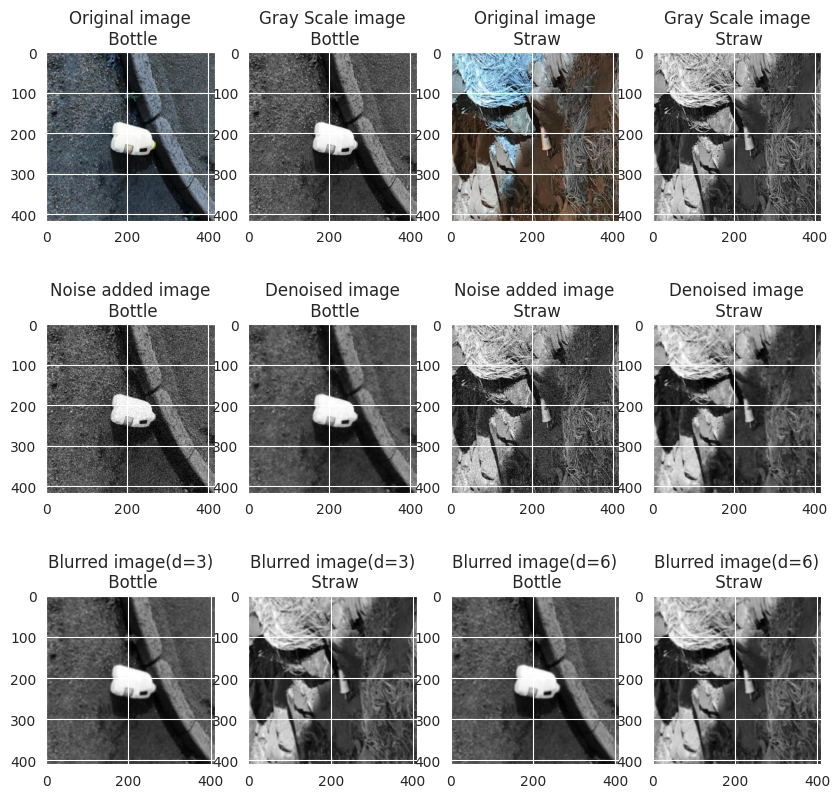

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.color as skic
import skimage.filters as skif
import skimage.data as skid
import skimage.util as sku
%matplotlib inline

img_path_1 = '/content/gdrive/MyDrive/MyDataset/TacoYolo/train/images/000000_JPG_jpg.rf.2a350b240c67942b0c4a9e076fec45c4.jpg'
img_1 = cv2.imread(img_path_1)
img_path_2 = '/content/gdrive/MyDrive/MyDataset/TacoYolo/train/images/000002_jpg.rf.f23cfe1b27c3fe8aa5141920daf5e0ad.jpg'
img_2 = cv2.imread(img_path_2)

#gray scale conversion
img_1_gray = skic.rgb2gray(img_1)
img_2_gray = skic.rgb2gray(img_2)

# We add Gaussian noise and denoise using denoise_tv_bregman approach
#for img_1 and img_2
img_1_n = sku.random_noise(skic.rgb2gray(img_1))
img_1_d = skimage.restoration.denoise_tv_bregman(img_1_n, 5.)
img_2_n = sku.random_noise(skic.rgb2gray(img_2))
img_2_d = skimage.restoration.denoise_tv_bregman(img_2_n, 5.)

#Noise reduction using Gaussian Blur
d=3
img_1_blur3 = cv2.GaussianBlur(skic.rgb2gray(img_1), (2*d+1, 2*d+1), -1)[d:-d,d:-d]
img_2_blur3 = cv2.GaussianBlur(skic.rgb2gray(img_2), (2*d+1, 2*d+1), -1)[d:-d,d:-d]
img_1_blur6 = cv2.GaussianBlur(skic.rgb2gray(img_1), (2*d+1, 2*d+1), -1)[d:-d,d:-d]
img_2_blur6 = cv2.GaussianBlur(skic.rgb2gray(img_2), (2*d+1, 2*d+1), -1)[d:-d,d:-d]

plt.figure(figsize=(10,10))
#VisualisingGray scale images visualisation
plt.subplot(341), plt.imshow(img_1),plt.title('Original image\n Bottle')
plt.subplot(342), plt.imshow(img_1_gray, cmap = 'gray'),plt.title('Gray Scale image\n Bottle')
plt.subplot(343), plt.imshow(img_2),plt.title('Original image\n Straw')
plt.subplot(344), plt.imshow(img_2_gray, cmap = 'gray'),plt.title('Gray Scale image\n Straw')

#Visualising Noising-Denoising images
plt.subplot(345), plt.imshow(img_1_n,cmap = 'gray'), plt.title('Noise added image\n Bottle')
plt.subplot(346), plt.imshow(img_1_d,cmap = 'gray'),plt.title('Denoised image\n Bottle')
plt.subplot(347), plt.imshow(img_2_n,cmap = 'gray'),plt.title('Noise added image\n Straw')
plt.subplot(348), plt.imshow(img_2_d,cmap = 'gray'),plt.title('Denoised image\n Straw')

#Visualising Noise Reduction with Gaussian Blurring
plt.subplot(349), plt.imshow(img_1_blur3,cmap = 'gray'), plt.title('Blurred image(d=3)\n Bottle')
plt.subplot(3,4,10), plt.imshow(img_2_blur3,cmap = 'gray'),plt.title('Blurred image(d=3)\n Straw')
plt.subplot(3,4,11), plt.imshow(img_1_blur6,cmap = 'gray'),plt.title('Blurred image(d=6)\n Bottle')
plt.subplot(3,4,12), plt.imshow(img_2_blur6,cmap = 'gray'),plt.title('Blurred image(d=6)\n Straw')
#################################################################


**EDA Steps/Questions**
*How discriminative are the salient features such as edges and corners for images corresponding to each class?*

(<Axes: title={'center': 'Image with Corners\n Straw'}>,
 Text(0.5, 1.0, 'Image with Corners\n Straw'))

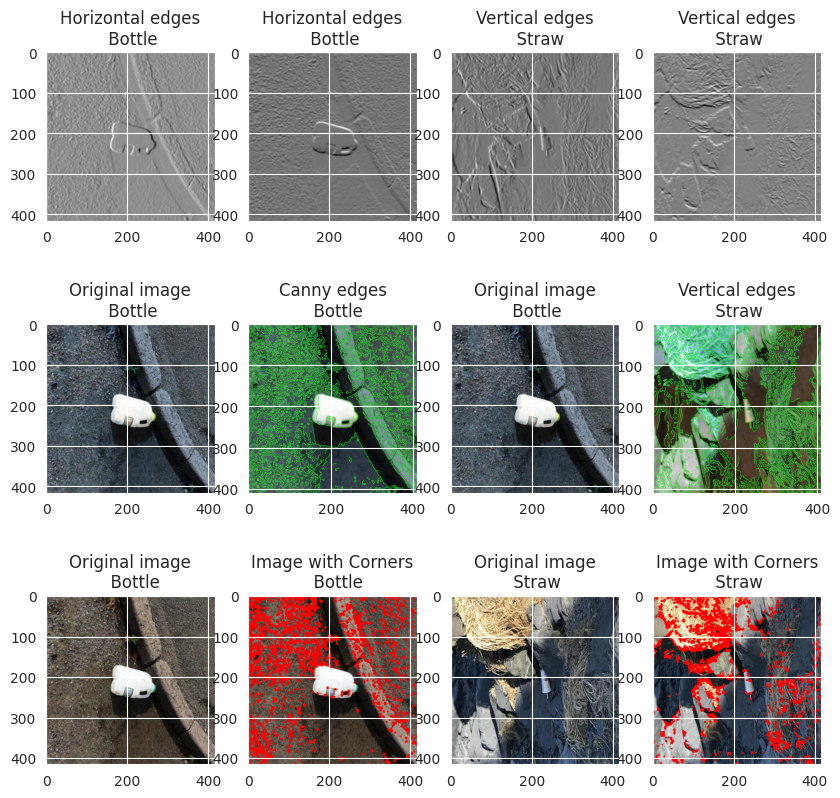

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.color as skic
import skimage.filters as skif
import skimage.data as skid
import skimage.util as sku
%matplotlib inline

img_path_1 = '/content/gdrive/MyDrive/MyDataset/TacoYolo/train/images/000000_JPG_jpg.rf.2a350b240c67942b0c4a9e076fec45c4.jpg'
img_1 = cv2.imread(img_path_1)
img_path_2 = '/content/gdrive/MyDrive/MyDataset/TacoYolo/train/images/000002_jpg.rf.f23cfe1b27c3fe8aa5141920daf5e0ad.jpg'
img_2 = cv2.imread(img_path_2)

#Sobel edge detector
#edge detector works on gray scale images
sobel_img_1=cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)
sobel_img_2=cv2.cvtColor(img_2,cv2.COLOR_BGR2GRAY)
sobelx_img_1 = cv2.Sobel(sobel_img_1,cv2.CV_64F,1,0,ksize=9)
sobely_img_1 = cv2.Sobel(sobel_img_1,cv2.CV_64F,0,1,ksize=9)
sobelx_img_2 = cv2.Sobel(sobel_img_2,cv2.CV_64F,1,0,ksize=9)
sobely_img_2 = cv2.Sobel(sobel_img_2,cv2.CV_64F,0,1,ksize=9)
#Canny edge detector
#threshold selection
th1=30
th2=60
# Canny recommends threshold 2 is 3 times threshold 1
# you could try experimenting with this...
d=3
# gaussian blur
# this takes pixels in edgeresult where edge non-zero and colours them bright green
edgeresult_1=img_1.copy()
edgeresult_1 = cv2.GaussianBlur(edgeresult_1, (2*d+1, 2*d+1), -1)[d:-d,d:-d]
gray_1 = cv2.cvtColor(edgeresult_1, cv2.COLOR_BGR2GRAY)
edge_1 = cv2.Canny(gray_1, th1, th2)
edgeresult_1[edge_1 != 0] = (0, 255, 0)
edgeresult_2=img_2.copy()
edgeresult_2 = cv2.GaussianBlur(edgeresult_2, (2*d+1, 2*d+1), -1)[d:-d,d:-d]
gray_2 = cv2.cvtColor(edgeresult_2, cv2.COLOR_BGR2GRAY)
edge_2 = cv2.Canny(gray_2, th1, th2)
edgeresult_2[edge_2 != 0] = (0, 255, 0)
#Corner detector
#detecting corners for  image_1
harris_1=img_1.copy()
#greyscale it
gray = cv2.cvtColor(harris_1,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
blocksize=4 #
kernel_size=3 # sobel kernel: must be odd and fairly small
# run the harris corner detector
dst = cv2.cornerHarris(gray,blocksize,kernel_size,0.05) # parameters are blocksize, Sobel parameter and Harris threshold
#result is dilated for marking the corners, this is visualisation related and just makes them bigger
dst = cv2.dilate(dst,None)
#we then plot these on the input image for visualisation purposes, using bright red
harris_1[dst>0.01*dst.max()]=[0,0,255]
#detecting corners for image_2
harris_2=img_2.copy()
#greyscale it
gray = cv2.cvtColor(harris_2,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
blocksize=4 #
kernel_size=3 # sobel kernel: must be odd and fairly small
# run the harris corner detector
dst = cv2.cornerHarris(gray,blocksize,kernel_size,0.05) # parameters are blocksize, Sobel parameter and Harris threshold
#result is dilated for marking the corners, this is visualisation related and just makes them bigger
dst = cv2.dilate(dst,None)
#we then plot these on the input image for visualisation purposes, using bright red
harris_2[dst>0.01*dst.max()]=[0,0,255]

#Visualisng Edges and Corners
plt.figure(figsize=(10,10))
#Visualising Sobel Edges
plt.subplot(341), plt.imshow(sobelx_img_1, cmap = 'gray'),plt.title('Horizontal edges\n Bottle')
plt.subplot(342), plt.imshow(sobely_img_1, cmap = 'gray'),plt.title('Horizontal edges\n Bottle')
plt.subplot(343), plt.imshow(sobelx_img_2, cmap = 'gray'),plt.title('Vertical edges\n  Straw')
plt.subplot(344), plt.imshow(sobely_img_2, cmap = 'gray'),plt.title('Vertical edges\n Straw')
#Visualising Canny Edges
plt.subplot(345), plt.imshow(img_1),plt.title('Original image\n Bottle')
plt.subplot(346), plt.imshow(edgeresult_1, cmap = 'gray'),plt.title('Canny edges\n  Bottle')
plt.subplot(347), plt.imshow(img_1),plt.title('Original image\n Bottle')
plt.subplot(348), plt.imshow(edgeresult_2, cmap = 'gray'),plt.title('Vertical edges\n Straw')
#Visualising Corners
plt.subplot(349), plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)),plt.title('Original image\n  Bottle')
plt.subplot(3,4,10), plt.imshow(cv2.cvtColor(harris_1, cv2.COLOR_BGR2RGB)),plt.title('Image with Corners\n  Bottle')
plt.subplot(3,4,11), plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)),plt.title('Original image\n Straw')
plt.subplot(3,4,12), plt.imshow(cv2.cvtColor(harris_2, cv2.COLOR_BGR2RGB)),plt.title('Image with Corners\n Straw')
#################################################################


**EDA Steps/Questions**
*How discriminative are the images from different categories in terms of illumination and lighting artefacts?*

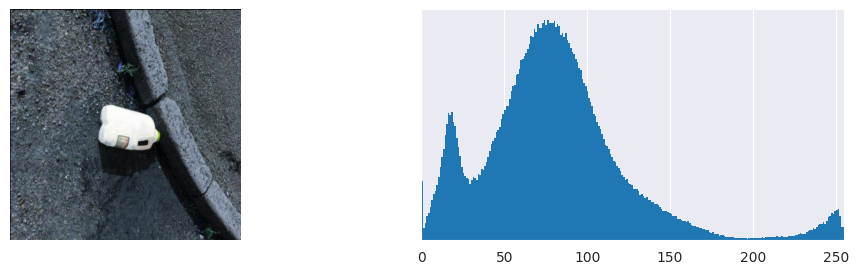

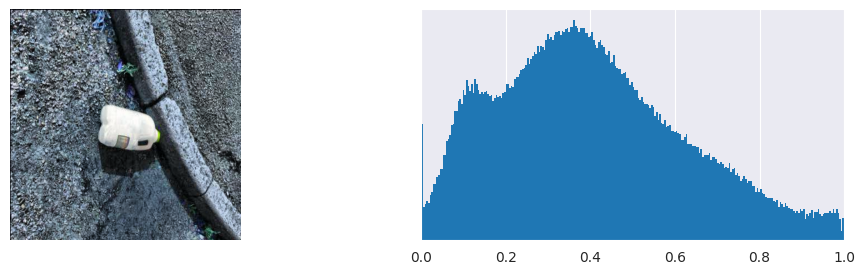

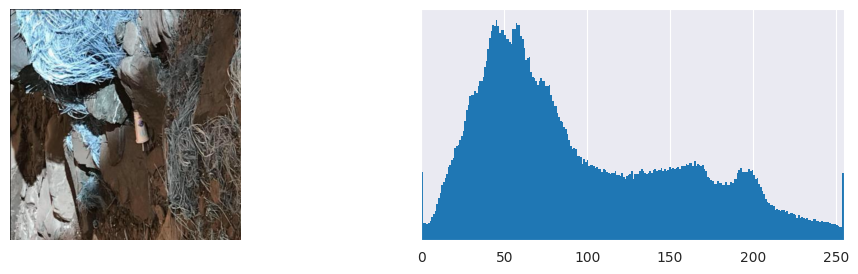

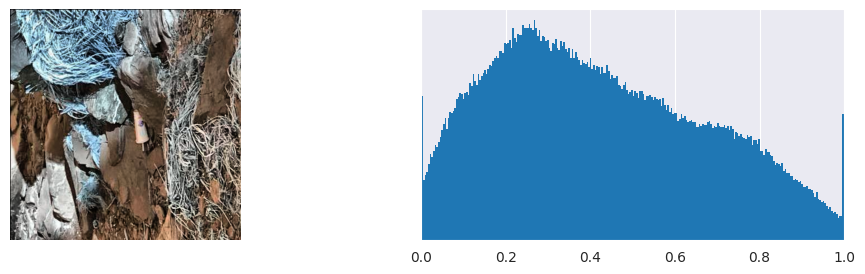

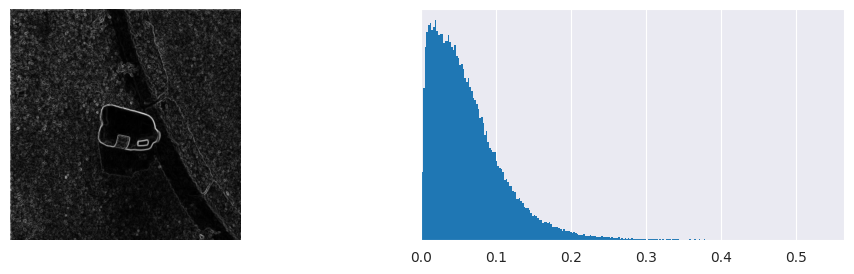

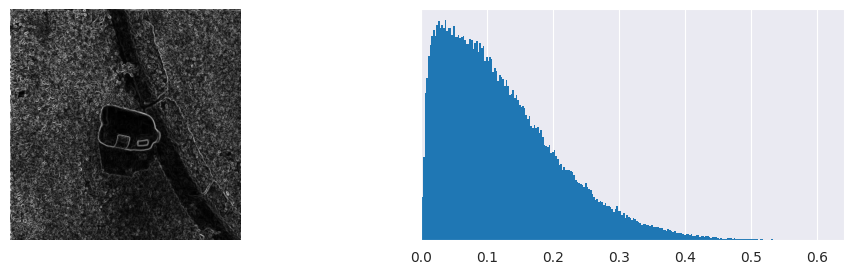

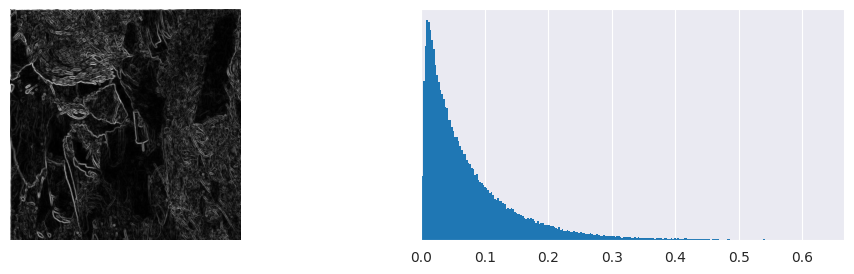

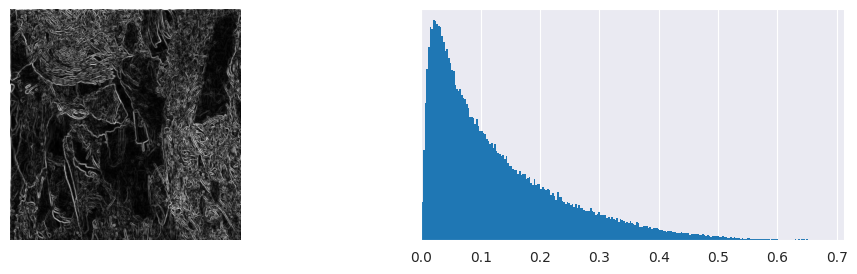

In [39]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage
import skimage.color as skic
import skimage.filters as skif
import skimage.data as skid
import skimage.util as sku
import skimage.exposure as skie
%matplotlib inline



img_path_1 = '/content/gdrive/MyDrive/MyDataset/TacoYolo/train/images/000000_JPG_jpg.rf.2a350b240c67942b0c4a9e076fec45c4.jpg'
img_1 = cv2.imread(img_path_1)
img_path_2 = '/content/gdrive/MyDrive/MyDataset/TacoYolo/train/images/000002_jpg.rf.f23cfe1b27c3fe8aa5141920daf5e0ad.jpg'
img_2 = cv2.imread(img_path_2)



def show(img):
    # Display the image.
    fig, (ax1, ax2) = plt.subplots(1, 2,
                                   figsize=(12, 3))
    ax1.imshow(img, cmap=plt.cm.gray)
    ax1.set_axis_off()

    # Display the histogram.
    ax2.hist(img.ravel(), lw=0, bins=256)
    ax2.set_xlim(0, img.max())
    ax2.set_yticks([])
    plt.show()
show(img_1)
# adaptive histogram equalisation
show(skie.equalize_adapthist(img_1))

show(img_2)
# adaptive histogram equalisation
show(skie.equalize_adapthist(img_2))

#class 1 image
img = skic.rgb2gray(img_1)
sobimg_nheq= skif.sobel(img)
show(sobimg_nheq)
img = skic.rgb2gray(skie.equalize_adapthist(img_1))
sobimg_heq_1 = skif.sobel(img)
show(sobimg_heq_1)
#class 2 image
img = skic.rgb2gray(img_2)
sobimg_nheq= skif.sobel(img)
show(sobimg_nheq)
img = skic.rgb2gray(skie.equalize_adapthist(img_2))
sobimg_heq_2 = skif.sobel(img)
show(sobimg_heq_2)


**Additional EDA Steps/Questions**
*How does the distribution look like? How many occurences are there from each class?*

This will help us understand if there is a class imbalance issue

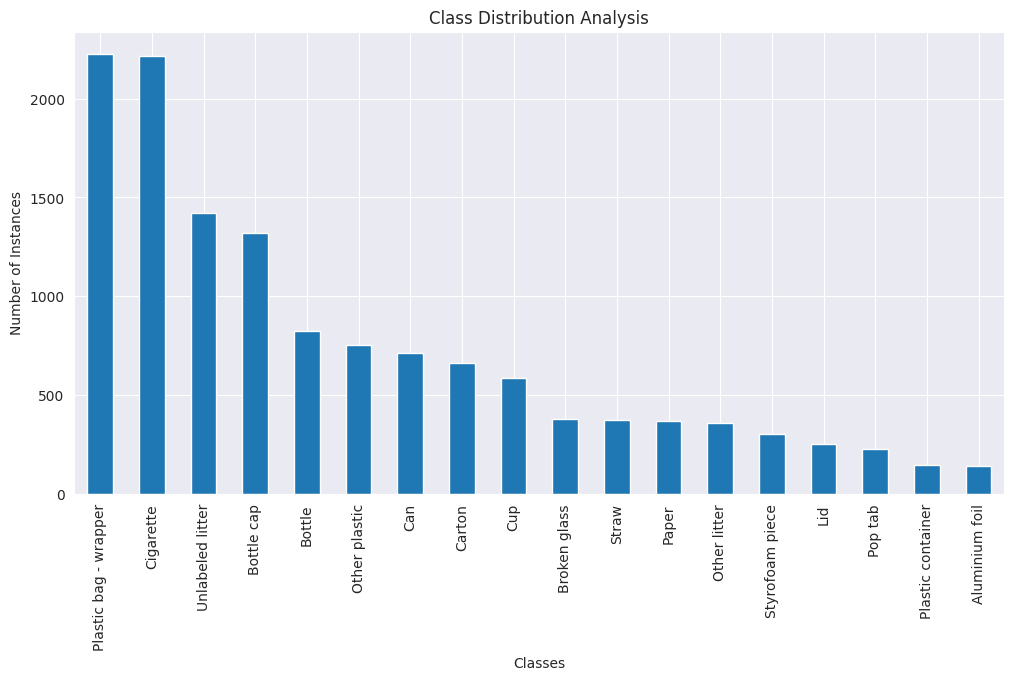

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

class_distribution = data['Class_Name'].value_counts()

# Create a bar plot
plt.figure(figsize=(12, 6))
class_distribution.plot(kind='bar')
plt.title('Class Distribution Analysis')
plt.xlabel('Classes')
plt.ylabel('Number of Instances')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()


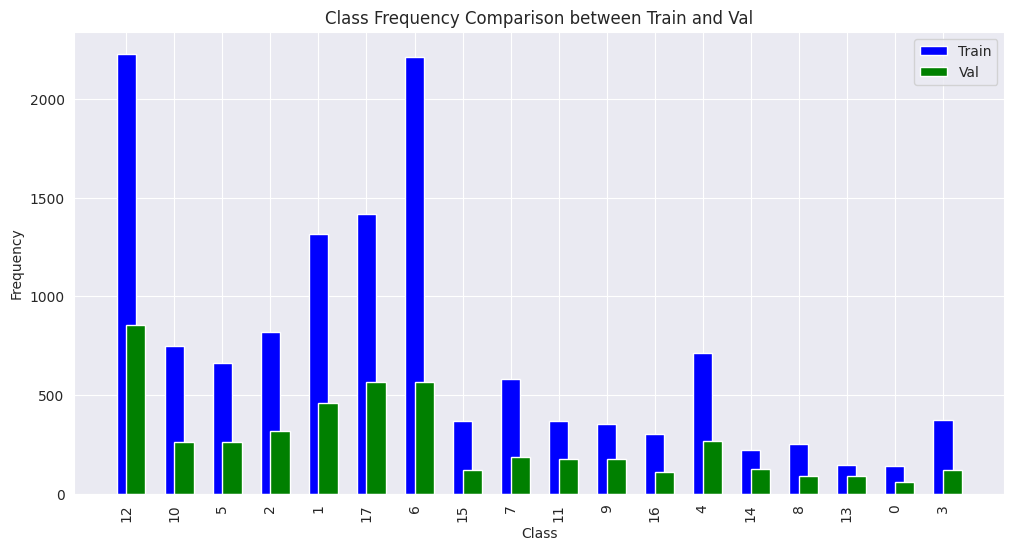

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

#Define the paths to the "train" and "val" folders (replace with your actual paths)
train_folder = '/content/gdrive/MyDrive/MyDataset/TacoYolo/train/labels'
val_folder = '/content/gdrive/MyDrive/MyDataset/TacoYolo/valid/labels'

train_class_freq = {}
val_class_freq = {}

class_distribution = data['Class_Name'].value_counts()

# Function to count class frequencies in a folder
def count_class_frequencies(folder, class_freq_dict):
    for filename in os.listdir(folder):
        with open(os.path.join(folder, filename), 'r') as file:
            lines = file.readlines()
            for line in lines:
                class_name = line.strip().split()[0]
                if class_name in class_freq_dict:
                    class_freq_dict[class_name] += 1
                else:
                    class_freq_dict[class_name] = 1

# Count class frequencies in the "train" folder
count_class_frequencies(train_folder, train_class_freq)

# Count class frequencies in the "val" folder
count_class_frequencies(val_folder, val_class_freq)

# Create a DataFrame to store class frequencies
class_freq_df = pd.DataFrame({
    'Class': list(train_class_freq.keys()),
    'Train_Frequency': list(train_class_freq.values()),
    'Val_Frequency': [val_class_freq.get(cls, 0) for cls in train_class_freq.keys()]
})

# Create a bar chart to compare class frequencies
plt.figure(figsize=(12, 6))
plt.bar(class_freq_df['Class'], class_freq_df['Train_Frequency'], width=0.4, label='Train', align='center', color='b')
plt.bar(class_freq_df['Class'], class_freq_df['Val_Frequency'], width=0.4, label='Val', align='edge', color='g')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Frequency Comparison between Train and Val')
plt.legend()
plt.xticks(rotation=90)
plt.show()



**Keras model from Teachable Machine**

In [48]:
from keras.models import load_model
from PIL import Image, ImageOps
import numpy as np

np.set_printoptions(suppress=True)

model_path = '/content/gdrive/MyDrive/MyDataset/converted_keras (1).zip (Unzipped Files)/keras_model.h5'
label_path = '/content/gdrive/MyDrive/MyDataset/converted_keras (1).zip (Unzipped Files)/labels.txt'

# Load the model
model = load_model(model_path, compile=False)

# Load the labels
class_names = open(label_path, "r").readlines()

# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Replace this with the path to your image
image = Image.open("/content/gdrive/MyDrive/MyDataset/TacoYolo/test/images/000003_JPG_jpg.rf.9ea3cfffc033c9a937d08ddb0bd21d60.jpg").convert("RGB")

# resizing the image to be at least 224x224 and then cropping from the center
size = (224, 224)
image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

# turn the image into a numpy array
image_array = np.asarray(image)

# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

# Load the image into the array
data[0] = normalized_image_array

# Predicts the model
prediction = model.predict(data)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Print prediction and confidence score
print("Class:", class_name[2:], end="")
print("Confidence Score:", confidence_score)


1/1 [==============================] - 8s 8s/step
Class: Straw
Confidence Score: 0.9998852


<dtype: 'uint8'>


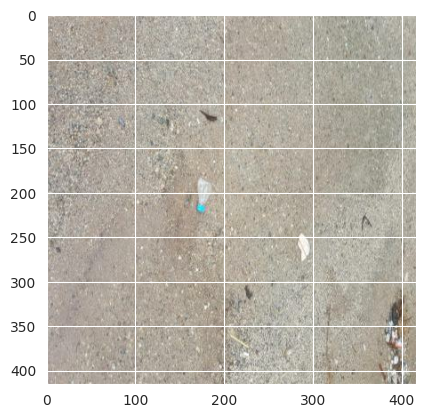

In [49]:
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt

filterwarnings("ignore")
tf_img = io.read_file("/content/gdrive/MyDrive/MyDataset/TacoYolo/test/images/000000_jpg.rf.1b029d4c742673020fa91367070f5f51.jpg")
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)
# plt.show()
